In [1]:
import numpy as np
import torch
import ot
import matplotlib.pylab as pl
import ot.plot

In [2]:
import sys
sys.path.append('../code/')
from generate_data import make_data
from sinkhorn_iterates import sinkhorn
from sinkhorn_iterates_logdomain import logsinkhorn
from linear_solver import UOT_W

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device='cpu'
dtype = torch.DoubleTensor
print('Used device: '+device)

Used device: cpu


In [4]:
n,d=50,2
np.random.seed(0)
X,Y=make_data('gaussians',n,d)
C=ot.dist(X,Y)

In [5]:
a=torch.ones((n,))/n
b=torch.ones((n,))/n
#b=torch.randint(1, 5, (n,),dtype=float)
#b/=torch.sum(b)
#b=b.float()

# Sinkhorn Algo

#### Banlanced OT

In [6]:
P=sinkhorn(a,b,C,eps=.5,numiter=300)
print(torch.sum(P*C))

tensor(8.4275)


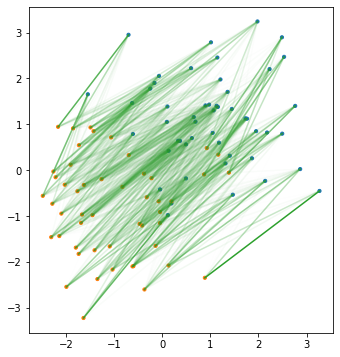

In [7]:
pl.figure(figsize=(12,6))
pl.subplot(1,2,1)
ot.plot.plot2D_samples_mat(X.numpy(), Y.numpy(), P.numpy(), c='C2')
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',s=a*500)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',s=b*500)

#### Penalization KL

In [8]:
P=sinkhorn(a,b,C,lam=20,lam2=20,eps=.3,pen="kl",numiter=100)
print(torch.sum(P))
print(torch.sum(P*C))

tensor(0.8809)
tensor(5.2393)


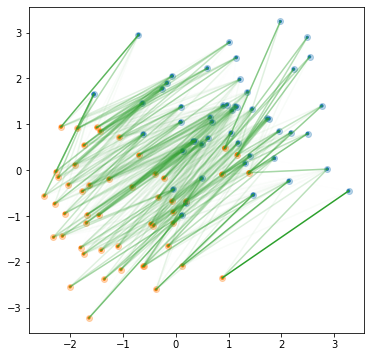

In [9]:
pl.figure(figsize=(6,6))
ot.plot.plot2D_samples_mat(X.numpy(), Y.numpy(), P.numpy(), c='C2')
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',s=torch.sum(P,axis=1)*500)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',s=torch.sum(P,axis=0)*500)
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',alpha=0.3)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',alpha=0.3)

#### Penalization Sinkhorn

In [10]:
P,Qx,Qy=sinkhorn(a,b,ot.dist(X,Y),lam=1e0,eps=.7,numiter=30,pen="sinkhorn",
               Cx=ot.dist(X,X),Cy=ot.dist(Y,Y),numiter2=10,innerplan=True)
print(torch.sum(P))
print(torch.sum(P*C))

tensor(1.)
tensor(2.4258)


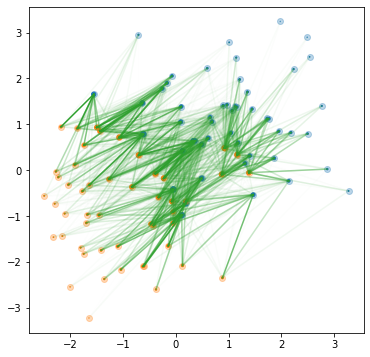

In [11]:
pl.figure(figsize=(6,6))
ot.plot.plot2D_samples_mat(X.numpy(), Y.numpy(), P.numpy(), c='C2')
#ot.plot.plot2D_samples_mat(X.numpy(), X.numpy(), Qx.numpy(), c='C0')
#ot.plot.plot2D_samples_mat(Y.numpy(), Y.numpy(), Qy.numpy(), c='C1')
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',s=torch.sum(P,axis=1)*500)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',s=torch.sum(P,axis=0)*500)
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',alpha=0.3)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',alpha=0.3)

In [12]:
#Other Data set

n,d=60,2
X,Y=make_data('mog_reg',n,d)
C=ot.dist(X,Y)

a=torch.ones((n,))/n
b=torch.ones((n,))/n

In [13]:
P,Qx,Qy=sinkhorn(a,b,ot.dist(X,Y),lam=1e-1,eps=1,numiter=100,pen="sinkhorn",
               Cx=ot.dist(X,X),Cy=ot.dist(Y,Y),numiter2=1,innerplan=True)
print(torch.sum(P))
print(torch.sum(P*C))

tensor(1.)
tensor(4.0083)


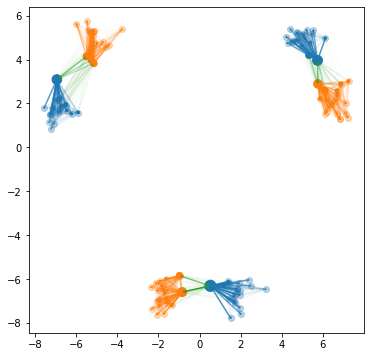

In [14]:
pl.figure(figsize=(6,6))
ot.plot.plot2D_samples_mat(X.numpy(), Y.numpy(), P.numpy(), c='C2')
ot.plot.plot2D_samples_mat(X.numpy(), X.numpy(), Qx.numpy(), c='C0')
ot.plot.plot2D_samples_mat(Y.numpy(), Y.numpy(), Qy.numpy(), c='C1')
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',s=torch.sum(P,axis=1)*500)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',s=torch.sum(P,axis=0)*500)
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',alpha=0.3)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',alpha=0.3)

### Penalization $\text{UOT}_\text{KL}$

In [15]:
P,Qx,Qy=sinkhorn(a,b,ot.dist(X,Y),lam=10,eps=1,numiter=100,pen="UOT_sinkhorn",
               Cx=ot.dist(X,X),Cy=ot.dist(Y,Y),lam3=10,numiter2=10,innerplan=True)
print(torch.sum(P))
print(torch.sum(P*C))

tensor(1.)
tensor(11.8285)


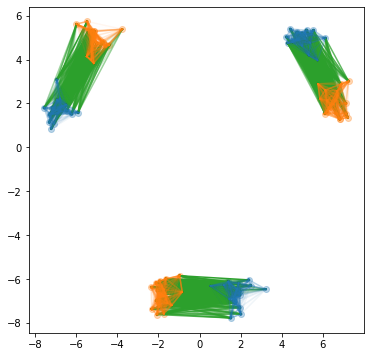

In [16]:
P/=torch.sum(P)
pl.figure(figsize=(6,6))
ot.plot.plot2D_samples_mat(X.numpy(), Y.numpy(), P.numpy(), c='C2')
ot.plot.plot2D_samples_mat(X.numpy(), X.numpy(), Qx.numpy(), c='C0')
ot.plot.plot2D_samples_mat(Y.numpy(), Y.numpy(), Qy.numpy(), c='C1')
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',s=torch.sum(P,axis=1)*500)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',s=torch.sum(P,axis=0)*500)
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',alpha=0.3)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',alpha=0.3)

# Linear solver

#### Penalization OT

In [17]:
C=ot.dist(X,Y)
Cx=ot.dist(X,X)
Cy=ot.dist(Y,Y)

P,Qx,Qy=UOT_W(a,b,C,lam=1,Cx=Cx,Cy=Cy,innerplan=True)

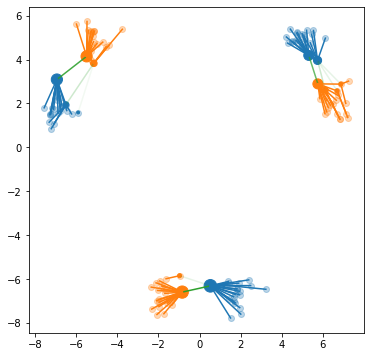

In [18]:
#P/=np.sum(P)
pl.figure(figsize=(6,6))
ot.plot.plot2D_samples_mat(X.numpy(), Y.numpy(), P, c='C2')
ot.plot.plot2D_samples_mat(X.numpy(), X.numpy(), Qx, c='C0')
ot.plot.plot2D_samples_mat(Y.numpy(), Y.numpy(), Qy, c='C1')
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',s=np.sum(P,axis=1)*500)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',s=np.sum(P,axis=0)*500)
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',alpha=0.3)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',alpha=0.3)

# Log domain Sinkhorn

#### KL penalization

In [19]:
P=logsinkhorn(a,b,C,lam=1,eps=.2,numiter=1000,lam2=None,pen="kl")
P.sum()

tensor(0.0744)

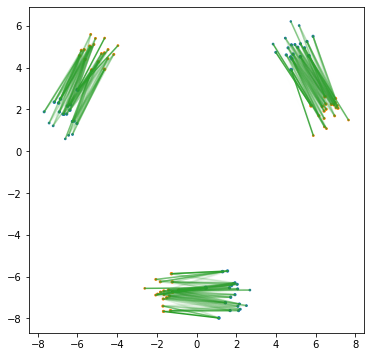

In [129]:
pl.figure(figsize=(6,6))
ot.plot.plot2D_samples_mat(X.numpy(), Y.numpy(), P.numpy(), c='C2')
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',s=torch.sum(P,axis=1)*500)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',s=torch.sum(P,axis=0)*500)

In [24]:
P,Qx,Qy=logsinkhorn(a,b,ot.dist(X,Y),lam=.1,eps=.5,numiter=100,pen="sinkhorn",
               Cx=ot.dist(X,X),Cy=ot.dist(Y,Y),numiter2=20,innerplan=True)
P.sum(),Qx.sum(),Qy.sum()

(tensor(1.0000), tensor(1.0000), tensor(1.0000))

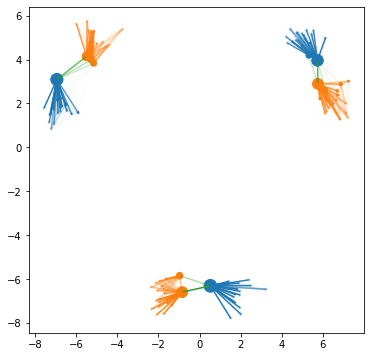

In [25]:
pl.figure(figsize=(6,6))
ot.plot.plot2D_samples_mat(X.numpy(), Y.numpy(), P.numpy(), c='C2')
ot.plot.plot2D_samples_mat(X.numpy(), X.numpy(), Qx.numpy(), c='C0')
ot.plot.plot2D_samples_mat(Y.numpy(), Y.numpy(), Qy.numpy(), c='C1')#
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',s=torch.sum(P,axis=1)*500)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',s=torch.sum(P,axis=0)*500)
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',s=a*500,alpha=.1)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',s=b*500,alpha=.1)

In [119]:
"""P,Qx,Qy=logsinkhorn(a,b,ot.dist(X,Y),lam=1e2,eps=5e0,numiter=50,pen="UOT_sinkhorn",
               Cx=ot.dist(X,X),Cy=ot.dist(Y,Y),numiter2=50,innerplan=True,lam3=1)
print(torch.sum(P))"""

'P,Qx,Qy=logsinkhorn(a,b,ot.dist(X,Y),lam=1e2,eps=5e0,numiter=50,pen="UOT_sinkhorn",\n               Cx=ot.dist(X,X),Cy=ot.dist(Y,Y),numiter2=50,innerplan=True,lam3=1)\nprint(torch.sum(P))'

In [120]:
"""pl.figure(figsize=(6,6))
ot.plot.plot2D_samples_mat(X.numpy(), Y.numpy(), P.numpy(), c='C2')
ot.plot.plot2D_samples_mat(X.numpy(), X.numpy(), Qx.numpy(), c='C0')
ot.plot.plot2D_samples_mat(Y.numpy(), Y.numpy(), Qy.numpy(), c='C1')
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',s=torch.sum(P,axis=1)*500)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',s=torch.sum(P,axis=0)*500)
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',alpha=0.3)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',alpha=0.3)"""

"pl.figure(figsize=(6,6))\not.plot.plot2D_samples_mat(X.numpy(), Y.numpy(), P.numpy(), c='C2')\not.plot.plot2D_samples_mat(X.numpy(), X.numpy(), Qx.numpy(), c='C0')\not.plot.plot2D_samples_mat(Y.numpy(), Y.numpy(), Qy.numpy(), c='C1')\npl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',s=torch.sum(P,axis=1)*500)\npl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',s=torch.sum(P,axis=0)*500)\npl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',alpha=0.3)\npl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',alpha=0.3)"